### Chapter9 - Text Clustering & Topic Modelling

### Import Libs:

In [1]:
import pandas as pd
import numpy as np
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
STOP_WORDS = stopwords.words()

from pymed import PubMed
pubmed = PubMed()

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")


C:\Users\Saleh Alkhalifa\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping, defaultdict
[nltk_data] Downloading package punkt to C:\Users\Saleh
[nltk_data]     Alkhalifa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Saleh
[nltk_data]     Alkhalifa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Generate Data:

In [35]:
def dataset_generator(query, num_results, ):
    results = pubmed.query(query, max_results=num_results)
    articleList = []
    for article in results:
        articleDict = article.toDict()
        articleList.append(articleDict)
    print(f"Found {len(articleList)} results for the query '{query}'.")
    df_tmp = pd.DataFrame(articleList)
    df_tmp["topic"] = query
    return df_tmp

In [81]:
df1 = dataset_generator("monoclonal antibodies", 600)
df2 = dataset_generator("machine learning", 600)
df3 = dataset_generator("covid-19", 600)
df4 = dataset_generator("particle physics", 600)

df = pd.concat([df1, df2, df3, df4])

Found 600 results for the query 'monoclonal antibodies'.
Found 600 results for the query 'machine learning'.
Found 600 results for the query 'covid-19'.
Found 600 results for the query 'particle physics'.


In [82]:
df.head()

,pubmed_id,title,abstract,keywords,journal,publication_date,authors,methods,conclusions,results,copyrights,doi,xml,isbn,language,publication_type,sections,publisher,publisher_location,topic
0,34454001,Development of a chemiluminescence immunoassay...,The outbreak of African swine fever (ASF) has ...,"[African swine fever virus, chemiluminescence ...",Journal of virological methods,2021-08-29,"[{'lastname': 'Yang', 'firstname': 'Yong', 'in...",NaN,None,None,Copyright © 2021. Published by Elsevier B.V.,10.1016/j.jviromet.2021.114269,"[[[], [<Element 'Year' at 0x0000018EA42D8680>,...",NaN,NaN,NaN,NaN,NaN,NaN,monoclonal antibodies
1,34453941,Mesenchymal stem cells in SARS-CoV-2 infection...,COVID-19 is a serious viral infection that str...,"[Antiviral, COVID-19, Clinical trial, Mesenchy...",Life sciences,2021-08-29,"[{'lastname': 'Pal', 'firstname': 'Deeksha', '...",NaN,None,None,Copyright © 2018. Published by Elsevier Inc.,10.1016/j.lfs.2021.119901,"[[[], [<Element 'Year' at 0x0000018EA42FF680>,...",NaN,NaN,NaN,NaN,NaN,NaN,monoclonal antibodies
2,34453188\n33592716\n33275408\n28813601\n333060...,Peroxidase-mimicking nanozyme with surface-dis...,Platinum-containing nanozymes with peroxidase-...,"[Cardiac markers, Core@shell nanoparticles, Ga...",Mikrochimica acta,2021-08-29,"[{'lastname': 'Panferov', 'firstname': 'Vasily...",NaN,None,None,"© 2021. The Author(s), under exclusive licence...",10.1007/s00604-021-04968-x\n10.1016/j.snb.2018...,"[[[], [<Element 'Year' at 0x0000018EA4306310>,...",NaN,NaN,NaN,NaN,NaN,NaN,monoclonal antibodies
3,34452926,Simultaneous engagement of tumor and stroma ta...,Metastatic castration resistant (mCRPC) prosta...,[],Cancer immunology research,2021-08-29,"[{'lastname': 'Hintz', 'firstname': 'Hallie M'...",NaN,None,None,"Copyright ©2021, American Association for Canc...",10.1158/2326-6066.CIR-21-0178,"[[[], [<Element 'Year' at 0x0000018EA43177C0>,...",NaN,NaN,NaN,NaN,NaN,NaN,monoclonal antibodies
4,34452912,No ordinary proteins: Adsorption and molecular...,The interaction of monoclonal antibodies (mAbs...,[],Science advances,2021-08-29,"[{'lastname': 'Kanthe', 'firstname': 'Ankit', ...",NaN,None,None,"Copyright © 2021 The Authors, some rights rese...",10.1126/sciadv.abg2873,"[[[], [<Element 'Year' at 0x0000018EA431E310>,...",NaN,NaN,NaN,NaN,NaN,NaN,monoclonal antibodies


In [88]:
len(df)

2263

In [89]:
df = df[["title", "abstract", "topic"]]
df.head()

,title,abstract,topic
0,Development of a chemiluminescence immunoassay...,The outbreak of African swine fever (ASF) has ...,monoclonal antibodies
1,Mesenchymal stem cells in SARS-CoV-2 infection...,COVID-19 is a serious viral infection that str...,monoclonal antibodies
2,Peroxidase-mimicking nanozyme with surface-dis...,Platinum-containing nanozymes with peroxidase-...,monoclonal antibodies
3,Simultaneous engagement of tumor and stroma ta...,Metastatic castration resistant (mCRPC) prosta...,monoclonal antibodies
4,No ordinary proteins: Adsorption and molecular...,The interaction of monoclonal antibodies (mAbs...,monoclonal antibodies


In [90]:
df["text"] = df["title"] + " " + df["abstract"]
df = df.dropna()
print(df.shape)
df.head()

(2263, 4)


,title,abstract,topic,text
0,Development of a chemiluminescence immunoassay...,The outbreak of African swine fever (ASF) has ...,monoclonal antibodies,Development of a chemiluminescence immunoassay...
1,Mesenchymal stem cells in SARS-CoV-2 infection...,COVID-19 is a serious viral infection that str...,monoclonal antibodies,Mesenchymal stem cells in SARS-CoV-2 infection...
2,Peroxidase-mimicking nanozyme with surface-dis...,Platinum-containing nanozymes with peroxidase-...,monoclonal antibodies,Peroxidase-mimicking nanozyme with surface-dis...
3,Simultaneous engagement of tumor and stroma ta...,Metastatic castration resistant (mCRPC) prosta...,monoclonal antibodies,Simultaneous engagement of tumor and stroma ta...
4,No ordinary proteins: Adsorption and molecular...,The interaction of monoclonal antibodies (mAbs...,monoclonal antibodies,No ordinary proteins: Adsorption and molecular...


In [91]:
df.text.str.len().mean()

1354.4339372514362

In [92]:
df.text.str.split(" ").apply(len).mean()

190.8965974370305

In [93]:
def cleaner(text):
    if type(text) == str:
        text = text.lower()
        text = re.sub("[^a-zA-Z]+", ' ', text)
        text_tokens = word_tokenize(text)
        tokens_without_sw = [word for word in text_tokens if not word in STOP_WORDS]
        filtered_sentence = (" ").join(tokens_without_sw)
        return filtered_sentence

In [94]:
df["text"] = df["text"].apply(lambda x: cleaner(x))

In [95]:
df.text.str.split(" ").apply(len).mean()

123.78789217852409

### Extract Features & Cluster

In [96]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [97]:
vectors = TfidfVectorizer(stop_words="english", max_features=2000)
vectors.fit(df.text.values)
features = vectors.transform(df.text.values)
features

<2263x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 124103 stored elements in Compressed Sparse Row format>

In [98]:
features.shape

(2263, 2000)

In [99]:
cls = MiniBatchKMeans(n_clusters=4)
cls.fit(features)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=4,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [100]:
df["cluster"] = cls.predict(features)

In [101]:
df[["text", "cluster"]].head()

,text,cluster
0,development chemiluminescence immunoassay accu...,1
1,mesenchymal stem cells sars cov infection hype...,1
2,peroxidase mimicking nanozyme surface disperse...,3
3,simultaneous engagement tumor stroma targeting...,2
4,ordinary proteins adsorption molecular orienta...,3


In [102]:
df.shape

(2263, 5)

In [103]:
pca = PCA(n_components=2)
pca_features_2d = pca.fit_transform(features.toarray())

pca_features_2d_centers = pca.transform(cls.cluster_centers_)

In [104]:
pca_features_2d.shape

(2263, 2)

In [105]:
pca_features_2d.shape

(2263, 2)

In [106]:
df["pc1"], df["pc2"] = pca_features_2d[:,0], pca_features_2d[:,1]

In [107]:
df[["text", "cluster", "topic", "pc1", "pc2"]].head()

,text,cluster,topic,pc1,pc2
0,development chemiluminescence immunoassay accu...,1,monoclonal antibodies,0.065504,-0.049324
1,mesenchymal stem cells sars cov infection hype...,1,monoclonal antibodies,0.173034,0.107094
2,peroxidase mimicking nanozyme surface disperse...,3,monoclonal antibodies,-0.086309,-0.110193
3,simultaneous engagement tumor stroma targeting...,2,monoclonal antibodies,0.011454,-0.098992
4,ordinary proteins adsorption molecular orienta...,3,monoclonal antibodies,-0.067632,-0.143511


In [108]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["topic_enc"] = lb_make.fit_transform(df["topic"])
df[["text", "cluster", "topic", "topic_enc", "pc1", "pc2"]].head()

,text,cluster,topic,topic_enc,pc1,pc2
0,development chemiluminescence immunoassay accu...,1,monoclonal antibodies,2,0.065504,-0.049324
1,mesenchymal stem cells sars cov infection hype...,1,monoclonal antibodies,2,0.173034,0.107094
2,peroxidase mimicking nanozyme surface disperse...,3,monoclonal antibodies,2,-0.086309,-0.110193
3,simultaneous engagement tumor stroma targeting...,2,monoclonal antibodies,2,0.011454,-0.098992
4,ordinary proteins adsorption molecular orienta...,3,monoclonal antibodies,2,-0.067632,-0.143511


In [109]:
import matplotlib

cmap_min = 0.3
cmap_max = 1.0
n = 10
cmap_orig = plt.cm.Blues
colors = cmap_orig(np.linspace(cmap_min, cmap_max, n))
new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors)

Text(0, 0.5, 'PC2')

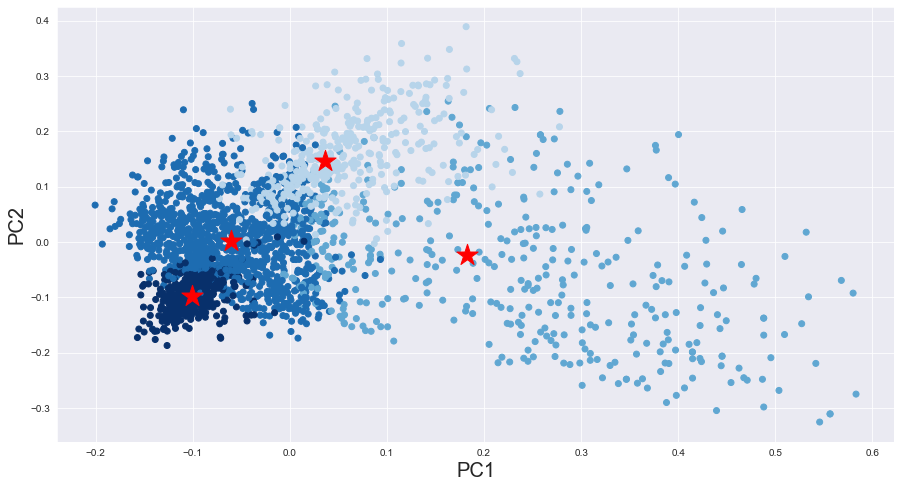

In [110]:
plt.figure(figsize=(15,8))
plt.scatter(df["pc1"], df["pc2"], c=df["cluster"], cmap=new_cmap)
plt.scatter(pca_features_2d_centers[:, 0], pca_features_2d_centers[:,1], marker='*', s=500, c='r')
plt.xlabel("PC1", fontsize=20)
plt.ylabel("PC2", fontsize=20)

Text(0, 0.5, 'PC2')

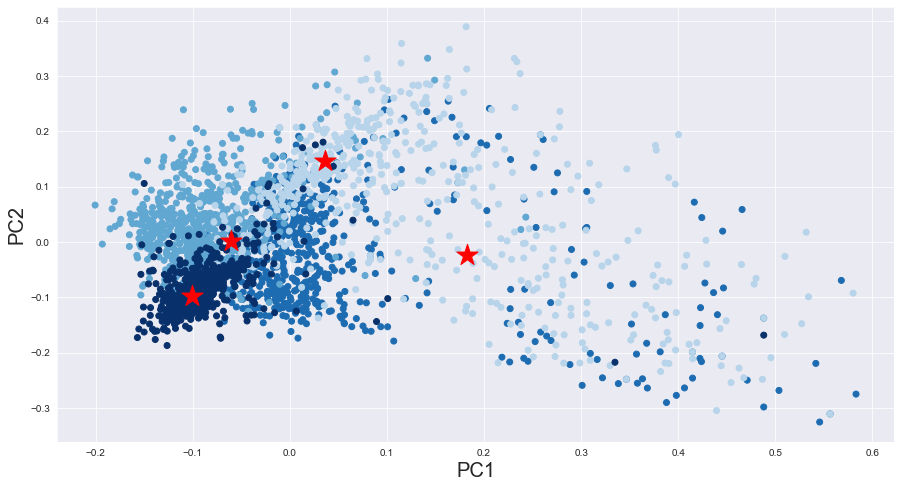

In [111]:
plt.figure(figsize=(15,8))
plt.scatter(df["pc1"], df["pc2"], c=df["topic_enc"], cmap=new_cmap)
plt.scatter(pca_features_2d_centers[:, 0], pca_features_2d_centers[:,1], marker='*', s=500, c='r')
plt.xlabel("PC1", fontsize=20)
plt.ylabel("PC2", fontsize=20)

In [112]:
from sklearn.metrics import homogeneity_score
homogeneity_score(df.topic_enc, df.cluster)

0.4259735720558103

In [113]:
df = df[["text", "cluster", "pc1", "pc2"]]

In [114]:
df.head()

,text,cluster,pc1,pc2
0,development chemiluminescence immunoassay accu...,1,0.065504,-0.049324
1,mesenchymal stem cells sars cov infection hype...,1,0.173034,0.107094
2,peroxidase mimicking nanozyme surface disperse...,3,-0.086309,-0.110193
3,simultaneous engagement tumor stroma targeting...,2,0.011454,-0.098992
4,ordinary proteins adsorption molecular orienta...,3,-0.067632,-0.143511


In [115]:
n_topics = df.cluster.nunique()
n_topics

4

In [138]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectors = TfidfVectorizer(max_features=5500, stop_words="english", max_df=0.95)
nmf_features = vectors.fit_transform(df.text)
# print(nmf_features)
from sklearn.decomposition import NMF
cls = NMF(n_components=n_topics)
cls.fit(features)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=4, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [139]:
feature_names = vectors.get_feature_names()

In [140]:
num_topic_words = 3

In [141]:
for i, j in enumerate(cls.components_):
    print(i, end=' ')
    for k in j.argsort()[-1:-num_topic_words-1:-1]:
        print(feature_names[k], end=' ')
    print()

0 consensus context covariates 
1 attributed elicited fibers 
2 atypical density delivering 
3 density ambient faces 
